# word2vec
이 장에서 다룰 것도 마찬가지로 단어의 분산표현이다. 여기서는 '추론에 기반한 방법'에 대해 알아볼 것이다.
먼저, word2vec을 실제로 코드로 짜보자!

## 추론 기반의 방법과 신경망
단어를 벡터로 표현한 방법 중, 성공한 것은 '카운트 기반 방법'과 '추론 기반 방법'이다. 이 두가지 방법의 배경에는 분배가설이 있다.

### 카운트 기반의 방법의 문제점
카운트 기반의 문제점은, 역시 어휘가 많아질 때 늘어난다. 어휘량이 100만개라고 할 때, 이 방식으로는 100만 x 100만의 거대한 행렬을 만들게 된다. 이 때, 이렇게 커다란 행렬에 대해 특이값분해를 하는 것은 현실적으로 불가능하다.

카운트 기반 방법은 코퍼스 전체의 통계 데이터(cocurrence matrix나 ppmi 등)을 이용해, 1회의 처리(SVD 등)으로 단어의 분산표현을 얻는다. 반면, 추론 기반 방법은 미니배치를 이용한 학습을 진행한다. 따라서 연산의 부하가 덜 걸리게 된다.

### 추론 기반의 방법 개요
추론 기반은 말 그대로 문맥이 주어졌을 때, 중간에 구멍을 뚫어놓고 어떤 단어가 출현할지 추측하는 것이다. 이런 추측을 거듭하여, 단어의 출현 패턴을 학습한다.

우리는 앞으로 신경망으로 단어를 처리할 것이다. 그러나, 'you'나 'will'같은 단어를 컴퓨터가 그대로 처리하지는 못한다. 신경망에 통과시키기 위해서는, 벡터로 변환할 필요가 있다. 이 방법 중 하나는 단어를 one-hot vector로 변환하는 것이다.

따라서, 모든 단어를 one-hot vector로 변환하면 이 벡터의 집합은 신경망을 구성하는 다양한 '레이어'에 의해 처리할 수 있다.
그렇다면 예를 들어보자. 

아래 예에서 c와 W의 내적은, 단순히 W의 행벡터를 "끄집어 내는" 것에 지나지 않는다. 비효율적이다. 그래서 ch4에서는 이를 개량한 코드를 작성할 것이다.

In [1]:
import numpy as np

# bias는 생략
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력층. 단어ID에 해당하는 원소는 1이고, 나머지는 0인 ONE-HOT VECTOR.
W = np.random.randn(7,3) # weight
h = np.dot(c, W) # 중간 노드
print(h)

[[-0.78644231 -1.06419704 -1.88519838]]


In [2]:
# Matmul layer를 사용해서 다시 쓸 수 있다.
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력층. 단어ID에 해당하는 원소는 1이고, 나머지는 0인 ONE-HOT VECTOR.
W = np.random.randn(7,3) # weight
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 2.12367396 -0.72416965 -1.58687127]]


## CBOW(Continuous Bag-of-words)
이제 신경망을 만들어 보자. word2vec에서 쓰이는 CBOW(Continuous Bag-of-words)라고 쓰이는 모델을 사용할 것이다.

사실 word2vec이라는 용어는 모델이 아니라, 프로그램의 이름이다. 정확히는 CBOW 모델과 skip-gram 모델이라는 두 가지 모델이 word2vec에 사용되는 신경망이다.

CBOW 모델은, 문맥에서 타겟(가운데 단어)을 추측하는 것을 목적으로 한 신경망이다. CBOW 모델이 입력받는 것은 문맥(컨텍스트)이다. 이 컨텍스트는 `['i', 'love', 'you']`와 같은 단어의 리스트로 표현된다. 이를 one-hot 표현으로 바꿔 CBOW 모델이 처리할 수 있게 변환할 것이다.

CBOW의 입력층은 문맥의 단어 개수에 따라 결정된다. 만약 문맥으로 N개의 단어를 다룬다면 입력층은 N개가 된다. 입력층에서 중간층의 변환은, 같은 Affine layer(weight: Win)에 의해 이루어진다. 그리고 중간층에서 출력층의 변환은 다른 Affine layer(weight: Wout)에 의해 이루어진다.

중간층에 있는 뉴런은, 각 입력층의 변환값의 '평균'이다. 이 뉴런들의 가중치 자체가 단어의 분산표현이 된다는 것에 주의하자. 학습을 거듭할수록 문맥으로부터 출현하는 단어를 잘 추측하도록 각 단어의 분산표현이 갱신된다. 또한, 중간층의 뉴런 수를 입력층보다 줄이는 것이 중요하다. 단어를 예측할 때 필요한 정보를 컴팩트하게 저장할 필요가 있기 때문이다.

또한, 출력층 뉴런들은 각 단어에 대응한다. 즉, 츌력층의 뉴런은 각 단어의 '스코어'이며, 이 스코어가 높을수록 대응하는 단어의 출현확률도 높아진다. 또한 스코어에 Softmax 함수를 적용하여 '확률'을 얻을 수 있다.

In [3]:
# CBOW Model의 추론처리 방법
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# Weight Init
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 레이어 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# Forward Propagation
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = (h0 + h1) / 2 # 레이어 2개를 더했으므로, 2로 나누어서 평균치를 구한다.
s = out_layer.forward(h)

print(s)

[[-1.25504528  2.0576921  -1.02357845 -0.85518541  0.32020726  1.85893387
   0.1182449 ]]


## CBOW 모델의 학습
CBOW모델은 코퍼스의 단어 출현패턴을 학습할 뿐이다. 따라서, 코퍼스가 달라지면, 학습으로 얻는 단어의 분산표현도 달라질 수 밖에 없다.

여기서 우리가 다루는 모델은 클래스의 분류를 하는 신경망이다. 따라서, 학습하기 위해서는 Softmax와 Cross Entropy Error를 이용한다. 여기서는 스코어를 Softmax로 확률로 변환하고, 그 확률과 정답 라벨의 Cross Entropy Error를 구한다. 그리고 그 손실을 통해 학습을 진행한다.

따라서 우리는 Softmax + Cross Entropy Error = Softmax with Loss를 구할 것이다.

## Word2vec의 가중치와 분산표현
word2vec에서 사용되는 신경망에는 2가지의 가중치가 존재한다. 하나는 입력층의 가중치(Win)과 출력층의 가중치(Wout)이다. 입력층의 가중치 Win의 각 행은 각 단어의 분산표현에 해당한다. 그리고 출력층의 가중치 Wout에도 단어의 의미가 인코딩된 벡터가 들어있다. 둘이 다른 건, 방향 뿐이다. 

그렇다면 이 두 가지 중에서 어떤 가중치를 쓸까? word2vec, 특히 skip-gram 모델에서는 입력층만을 이용한다. GloVe라는 방법은 두개의 가중치를 모두 이용한다.

## Context와 Target
자, 그럼 우리의 목표는 뭘까? Context가 주어질 때, Target이 출현하는 확률을 높이는 것이다. 그렇다면 코퍼스에서 Context와 Target을 우선 벡터로 따로 분리하는 작업을 진행해보자.






In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

text = "I want to study Python and you want to study JavaScript."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 5 6 1 2 3 7 8]
{0: 'i', 1: 'want', 2: 'to', 3: 'study', 4: 'python', 5: 'and', 6: 'you', 7: 'javascript', 8: '.'}


In [5]:
# context와 target을 출력해보자. corpus가 [0,1,2,3]이라면
# context는 [[0, 2], [1,3]], target은 [1, 2]로 출력하는 함수를 만들자.
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 5]
 [4 6]
 [5 1]
 [6 2]
 [1 3]
 [2 7]
 [3 8]]
[1 2 3 4 5 6 1 2 3 7]


In [6]:
# 이제 이 값들을 one-hot-vector로 바꿔서 CBOW 모델에 주자.
def convert_one_hot(corpus, vocab_size):
    """
    :param corpus: 단어ID 리스트(1 or 2차원의 numpy 배열)
    :param vocab_size: 어휘수
    :return: one-hot 배열(2 or 3차원의 numpy 배열)
    """
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

# 위의 예제에서 계속.
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

이제 학습 데이터의 준비는 끝났다. CBOW 모델을 실제 코드로 옮겨보자.
먼저, SoftMaxWithLoss layer를 코드로 작성하자.

In [7]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 one-hot-vector일 때, 정답 라벨의 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])

            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None # softmax 출력
        self.t = None # 정답라벨

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 라벨이 one-hot 벡터일 때, 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx /= batch_size

        return dx

In [9]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # parameter의 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') # float32형으로
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 grad를 리스트에 모음
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 멤버 변수에 단어의 분산표현을 설정
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) / 2
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)
        return None

# 이제 본격적으로 학습해보자.
import os
module_path = os.path.abspath(".")
from common.trainer import Trainer

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "I study Python and You study JavaScript."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
contexts = convert_one_hot(contexts, vocab_size)
target = convert_one_hot(target, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)

 epoch 601 |  iter 1 / 2 | time 1[s] | loss 0.76
| epoch 602 |  iter 1 / 2 | time 1[s] | loss 0.49
| epoch 603 |  iter 1 / 2 | time 1[s] | loss 0.91
| epoch 604 |  iter 1 / 2 | time 1[s] | loss 0.70
| epoch 605 |  iter 1 / 2 | time 1[s] | loss 0.56
| epoch 606 |  iter 1 / 2 | time 1[s] | loss 0.90
| epoch 607 |  iter 1 / 2 | time 1[s] | loss 0.62
| epoch 608 |  iter 1 / 2 | time 1[s] | loss 0.69
| epoch 609 |  iter 1 / 2 | time 1[s] | loss 0.70
| epoch 610 |  iter 1 / 2 | time 1[s] | loss 0.69
| epoch 611 |  iter 1 / 2 | time 1[s] | loss 0.62
| epoch 612 |  iter 1 / 2 | time 1[s] | loss 0.77
| epoch 613 |  iter 1 / 2 | time 1[s] | loss 0.63
| epoch 614 |  iter 1 / 2 | time 1[s] | loss 0.75
| epoch 615 |  iter 1 / 2 | time 1[s] | loss 0.63
| epoch 616 |  iter 1 / 2 | time 1[s] | loss 0.75
| epoch 617 |  iter 1 / 2 | time 1[s] | loss 0.56
| epoch 618 |  iter 1 / 2 | time 1[s] | loss 0.76
| epoch 619 |  iter 1 / 2 | time 1[s] | loss 0.82
| epoch 620 |  iter 1 / 2 | time 1[s] | loss 0.48
|

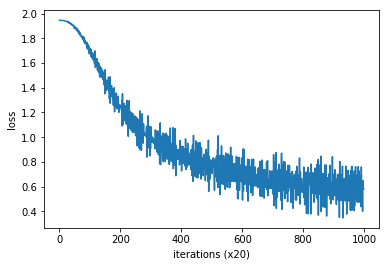

In [10]:
trainer.plot()

In [11]:
word_vecs = model.word_vecs

# 각 단어를 벡터로 표현했다!! 이것이 단어의 분산표현이다.
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

i [-1.0901577  1.1491778  1.078492  -1.1051644 -1.2962   ]
study [ 1.154049   -1.1632253  -1.186218    1.1233807  -0.01793403]
python [-0.7974376   0.6964599   0.7716731  -0.78829056 -0.68517363]
and [ 0.89068294 -0.8980191  -0.85832137  0.86041087 -2.037612  ]
you [-0.779569    0.70580465  0.77850765 -0.7886558  -0.7089577 ]
javascript [-1.0965396  1.1460419  1.0555729 -1.101946  -1.2720102]
. [ 1.0861663 -1.1255072 -1.1605011  1.1106279  1.6983181]


## CBOW 모델과 확률
CBOW는 주변 단어들로 가운데 target을 추측하는 방법이다. 이를 확률로 나타내면 다음과 같다.
- P(wt | wt-1, wt+1)

이는, wt-1과 wt+1이 일어난 후에 wt가 일어날 확률을 뜻한다. 여기에 Cross Entropy Error를 적용하면, 다음과 같은 식이 된다.
- L = -logP(wt | wt-1, wt+1)

단순히 확률에 대해 로그를 취하고 마이너스를 더한 값이다. 이는 negative log likelihood라고 불린다! 이 식은 한 개의 샘플 데이터에 대한 손실함수이므로, 이를 코퍼스 전체로 확장하면 아래와 같은 식이 된다.
- L = -(1/T)시그마(t=1 ~ T)logP(wt | wt-1, wt+1)

CBOW 모델으로 학습을 진행한다는 것은, 위 L값을 최대한 작게한다는 것이다.

## Skip-gram
skip-gram은 가운데 단어가 주어졌을 때, 주변의 단어를 추측하는 방법이다. CBOW와 반대지. 그래서 신경망의 구조도 반대가 된다.

입력층이 한개고, 출력층이 문맥의 수만큼 존재한다. 그렇다면 이를 확률로 나타낸다면 어떻게 될까? 
- P(wt-1, wt+1 | wt)

가 될 것이다. skip-gram모델에서는 문맥의 단어 사이에 관련성이 없다고 판단하기 때문에, 이를 다음과 같이 풀 수 있다.
- P(wt-1 | wt)P(wt+1 | wt)

여기에 cross entropy error를 적용하면, 
- L = -(1/T)시그마(t=1 ~ T)(P(wt-1 | wt) + P(wt+1 | wt))이 된다.

그렇다면, CBOW와 skip-gram 중 뭘 써야 할까? 답은 skip-gram이다. 코퍼스가 커지면 커질수록 저빈도의 단어나 유추문제 성능 면에서 더 우수한 게 증명되었기 때문이다. 다만 학습속도에서는 CBOW가 더 우수하다. 왜냐? skip-gram 모델은 문맥 수만큼 손실을 구해야 하기 때문에, 계산이 그만큼 복잡해지기 때문이다(위의 L을 비교하면 알 수 있음).